# <font color = 'pickle'>**Handling Long Sequence - Chunking** </font>

# <font color = 'pickle'>**MultiClass Classification- Stack Dataset** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Exploring and Understanding IMDB Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/Google_Colab") #


from functools import partial
import torch.nn.functional as F
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate
import torch.nn as nn
from transformers.trainer_utils import EvalPrediction
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
import textwrap
import gc
from datasets import load_dataset, DatasetDict
import torch
from transformers import PreTrainedModel
from evaluate import load
from collections import Counter
from torch.utils.data import DataLoader
from scipy.special import logsumexp
from scipy.special import softmax
import wandb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##sys.path

In [ ]:
data_folder = base_folder/'csv_file'
model_folder = base_folder/"Models"
model_folder.mkdir(exist_ok=True)

In [ ]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

In [ ]:
df1 = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

# <font color = 'pickle'>**Understanding the data** </font>

In [ ]:
print(df1)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


In [ ]:
df1['train'].features           # [:, [2, 3, 4, 5, 6, 7, 8]]

{'Unnamed: 0.1': Value(dtype='int64', id=None),
 'Unnamed: 0': Value(dtype='int64', id=None),
 'Title': Value(dtype='string', id=None),
 'Body': Value(dtype='string', id=None),
 'cleaned_text': Value(dtype='string', id=None),
 'Tags': Value(dtype='string', id=None),
 'Tag_Number_final': Value(dtype='int64', id=None),
 'combined_text': Value(dtype='string', id=None),
 'basic_cleaned_text': Value(dtype='string', id=None)}

In [ ]:
selected_columns = {
    'text': df1['train']['basic_cleaned_text'],
    'label': df1['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
df2 = Dataset.from_dict(selected_columns)

In [ ]:
print(df1)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'Title', 'Body', 'cleaned_text', 'Tags', 'Tag_Number_final', 'combined_text', 'basic_cleaned_text'],
        num_rows: 188878
    })
})


In [ ]:
print(df2)

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})


## <font color = 'pickle'> **Exploratory Data Analysis (EDA)**

In [ ]:
# Convert to Pandas
df2.set_format(type='pandas')

In [ ]:
df2_train = df2[:]

In [ ]:
df2_train.head()

,text,label
0,detail disclosure indicator on UIButton Is the...,8
1,hello world fails to show up in emulator I fol...,4
2,"Why is JSHint throwing a ""possible strict viol...",3
3,Programmatically Make Bound Column Invisible I...,9
4,"More than one EditText - not getting focus, no...",4


### <font color = 'pickle'> **Check length of the reviews** </font>


In [ ]:
df2_train['words_per_review'] = df2_train['text'].apply(lambda x: len(str(x).split()) if x is not None else 0)
df2_train.head()

,text,label,words_per_review
0,detail disclosure indicator on UIButton Is the...,8,80
1,hello world fails to show up in emulator I fol...,4,256
2,"Why is JSHint throwing a ""possible strict viol...",3,40
3,Programmatically Make Bound Column Invisible I...,9,60
4,"More than one EditText - not getting focus, no...",4,197


In [ ]:
df2_train.shape[0]

188878

In [ ]:
len(df2_train[df2_train.words_per_review > 400])

4772

In [ ]:
df_final = df2_train[df2_train.words_per_review > 400]

In [ ]:
df_final.shape

(4772, 3)

In [ ]:
#Label Distribution
df_final.label.value_counts(normalize = True, ascending = True)

8    0.019279
9    0.029966
7    0.051551
5    0.060142
3    0.065381
0    0.083403
6    0.100587
2    0.113789
1    0.137469
4    0.338433
Name: label, dtype: float64

<Axes: >

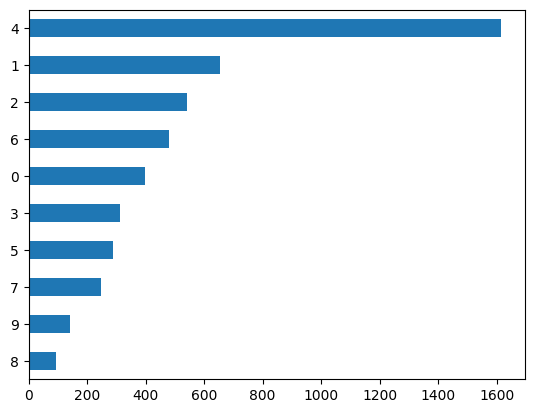

In [ ]:
# check distribution of class labels in the dataset
df_final['label'].value_counts(ascending=True).plot.barh()



**Above Plot clearly shows that there is a imblance in the dataset, Label id-4 is highly dominating**






```

```

### <font color = 'pickle'> **Plot the distribution of review length** </font>

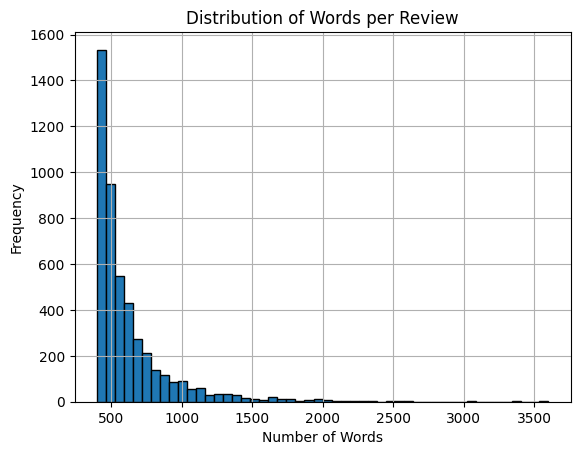

In [ ]:
# Plot a histogram of the 'words_per_review' column
df_final['words_per_review'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


<Axes: title={'center': 'words_per_review'}, xlabel='label'>

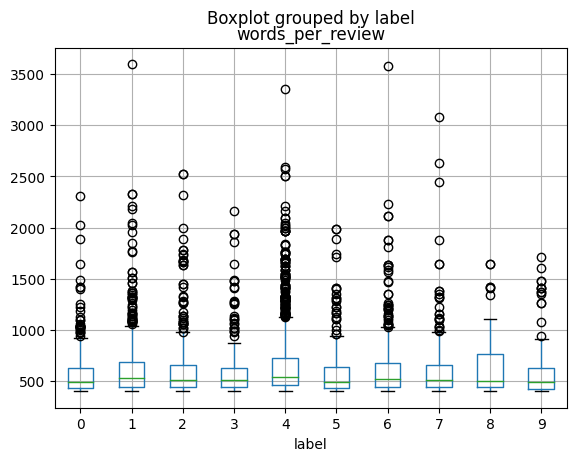

In [ ]:
# distribution of number of words for each class label
df_final.boxplot('words_per_review', by='label')

#  <font color = 'pickle'> **Initializing the class weight function**

In [ ]:
# 1. Compute the class frequencies:
class_weights = df2['label'].value_counts(normalize=True, sort=False)

# 2. Sort weights by index (i.e., by label):
class_weights = class_weights.sort_index()

# 3. Compute the inverse of the class frequencies:
class_weights = 1/class_weights

# 4. Normalize the weights so they sum up to 1 (this step is optional but can be useful):
class_weights = class_weights / class_weights.sum()

# 5. Convert the weights to a PyTorch tensor:
class_tensor_weights = torch.tensor(class_weights.values, dtype=torch.float)
class_tensor_weights

tensor([0.0864, 0.0834, 0.0646, 0.0791, 0.0396, 0.0701, 0.1296, 0.1194, 0.1576,
        0.1700])

In [ ]:
# Restting the format
df2.reset_format()
print(df2)

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})


In [ ]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
df2 = df2.cast_column('label', ClassLabel(names = class_names))

Casting the dataset:   0%|          | 0/188878 [00:00<?, ? examples/s]

We can observe that the text are now categorical data instead of numbers

### <font color = 'pickle'> **Filtering text colmn>400 words** </font>

In [ ]:
def filter_long_samples(ex):
  text = ex['text']
  return text is not None and len(text.split()) > 400

In [ ]:
df_final = df2.filter(filter_long_samples)
df_final

Filter:   0%|          | 0/188878 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 4772
})

In [ ]:
# First, split the dataset into a 60% training set and a 40% temporary set (to be further split).
# Use stratified sampling based on the 'label' column to ensure that each split has a similar distribution of labels.
test_val_splits = df_final.train_test_split(test_size=0.4, stratify_by_column="label", seed=42)

# Extract the 60% training dataset.
train_split = test_val_splits['train']

# # Split the 40% temporary set into two equal parts: validation (20%) and test (20%).
# # Again, use stratified sampling based on the 'label' column.
test_val_splits_new = test_val_splits['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)

# Extract the validation and test datasets.
val_split = test_val_splits_new['train']
test_split = test_val_splits_new['test']

In [ ]:
test_val_splits

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2863
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1909
    })
})

In [ ]:
test_val_splits_new

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 954
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 955
    })
})

### <font color = 'pickle'> **Create small subset for experimentation** </font>

In [ ]:
train_split_small = train_split.shuffle(seed=42).select(range(10))
val_split_small = val_split.shuffle(seed=42).select(range(10))
test_split_small = test_split.shuffle(seed=42).select(range(10))

# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split_small})

In [ ]:
train_val_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 10
    })
})

In [ ]:
train_val_dataset.set_format(type = 'pandas')

<Axes: >

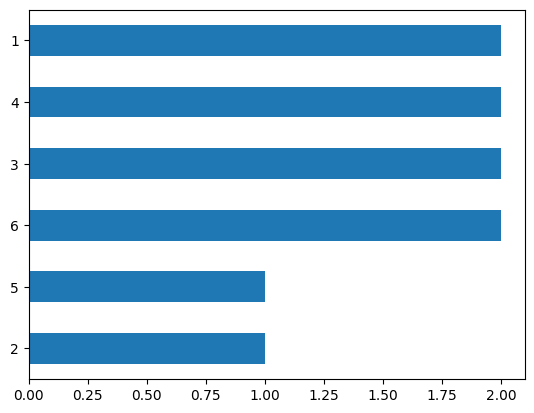

In [ ]:
train_val_dataset['train']['label'].value_counts(ascending = True).plot.barh()

In [ ]:
train_val_dataset.reset_format()

In [ ]:
train_val_dataset = train_val_dataset.cast_column('label', ClassLabel(names = class_names))

Casting the dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
train_val_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

#  <font color = 'pickle'> **Collate functionn**

In [ ]:
def collate_function(batch, tokenizer, max_length, stride):

  text_batch = [item['text'] for item in batch]

  # Check if any of the batch items has 'label', if so process labels.
  if all('label' in item for item in batch):
    label_batch = [item['label'] for item in batch]
    doc_labels = torch.tensor(label_batch, dtype=torch.long)
  else:
    doc_labels = None


    # Tokenize the batch of texts
  tokenized = tokenizer(text_batch,
                        padding='longest',
                        truncation=True,
                        return_tensors='pt',
                        max_length=max_length,
                        return_overflowing_tokens=True,
                        stride=stride)

  # Flatten the chunks if necessary using overflow_to_sample_mapping
  overflow_to_sample_mapping = tokenized.get("overflow_to_sample_mapping", None)

  result = {
      **tokenized,
      "overflow_to_sample_mapping": overflow_to_sample_mapping
      }

  # Repeat labels for the chunks based on overflow_to_sample_mapping, only if labels are present
  if doc_labels is not None and overflow_to_sample_mapping is not None:
    labels = doc_labels[overflow_to_sample_mapping]
    result["labels"] = labels
    result["doc_labels"] = doc_labels

  return result

#  <font color = 'pickle'> **Initialize model**

In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

    return model, config

#  <font color = 'pickle'> **Aggregate Predictions**

In [ ]:
def stable_log_softmax(x):
    # Subtract the max for numerical stability along the last axis (axis=-1)
    x_max = np.max(x, axis=-1, keepdims=True)
    # Use logsumexp for better numerical stability
    log_softmax = x - x_max - logsumexp(x - x_max, axis=-1, keepdims=True)

    return log_softmax

def aggregate_predictions(logits, aggregation_method, overflow_to_sample_mapping):

  probabilities = softmax(logits, axis=-1)
  log_probabilities = stable_log_softmax(logits)

  # print('log_probs', log_probabilities.shape)
  # print('overflow_to_sample_mapping', overflow_to_sample_mapping.shape)

  # Get unique documents

  unique_docs, inverse_indices = np.unique(overflow_to_sample_mapping, return_inverse=True)
  num_docs = unique_docs.size

  # Create a mask for documents
  mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

  # Initialize the aggregated_predictions variable
  aggregated_predictions = None

  if aggregation_method == "average_log_probs":
    # Compute average probabilities using NumPy
    avg_log_probs = (log_probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
    aggregated_predictions = np.argmax(avg_log_probs, axis=-1)
    scores = np.exp(avg_log_probs.max(axis=-1))

  elif aggregation_method == "average_probs":
    # Compute average probabilities using NumPy
    avg_probs = (probabilities[:, None, :] * mask[:, :, None].astype(float)).sum(axis=0) / mask.sum(axis=0, keepdims=True).transpose((1, 0))
    aggregated_predictions = np.argmax(avg_probs, axis=-1)
    scores  = avg_probs.max(axis=-1)

  elif aggregation_method == "max_probs":
    # Compute max probabilities per document
    max_values = np.where(mask[:, :, None], log_probabilities[:, None, :], float('-inf'))
    max_log_probs = np.max(max_values, axis=0)
    aggregated_predictions = np.argmax(max_log_probs, axis=-1)
    scores = np.exp(max_log_probs.max(axis=-1))

  elif aggregation_method == "majority_vote":
    # Convert logits to actual predictions before voting
    predictions = np.argmax(logits, axis=1)
    # Tally the votes for each document
    vote_tally = np.zeros((num_docs, logits.shape[-1]), dtype=int)
    np.add.at(vote_tally, overflow_to_sample_mapping, np.eye(logits.shape[-1], dtype=int)[predictions])
    # Determine the majority vote for each document
    aggregated_predictions = np.argmax(vote_tally, axis=1)
    scores = vote_tally.max(axis=-1) / vote_tally.sum(axis=-1)
  else:
    raise ValueError(f"Unsupported aggregation_method: {aggregation_method}")

    # # Calculate evaluation metrics using document-level labels
    # metrics = evaluate.combine([
    #     evaluate.load("accuracy"),
    #     evaluate.load("f1", average="macro")
    # ])
    # evaluations = metrics.compute(predictions=aggregated_predictions, references=doc_labels)

    # return evaluations

  return aggregated_predictions, scores

#  <font color = 'pickle'> **Custom Trainer**

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="average_log_probs", **kwargs):
        super(CustomTrainer, self).__init__(*args, **kwargs)
        self.loss_type = loss_type



    def compute_loss(self, model, inputs, return_outputs=False):

        labels = inputs["labels"]
        overflow_to_sample_mapping = inputs.pop("overflow_to_sample_mapping", None)
        doc_labels = inputs.pop("doc_labels", None)
        logits = model(**inputs).logits

        # convert logits to log probabilities, probabilities
        log_probabilities = F.log_softmax(logits, dim=-1)
        probabilities = F.softmax(logits, dim=-1)


        # Number of unique documents and chunks
        num_docs = doc_labels.size(0)
        num_chunks = overflow_to_sample_mapping.size(0)

        # Ensure overflow_to_sample_mapping is on the same device as doc_labels
        overflow_to_sample_mapping = overflow_to_sample_mapping.to(doc_labels.device)

        # Create a tensor representing each unique doc
        unique_docs = torch.arange(num_docs).to(doc_labels.device)

        # Create the mask
        mask = overflow_to_sample_mapping[:, None] == unique_docs[None, :]

        loss_fn = nn.NLLLoss(weight = class_tensor_weights.to(model.device))



        if self.loss_type == "average_log_probs":
            avg_log_probs = (log_probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = loss_fn( avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "average_probs":
            avg_probs = (probabilities[:, None, :] * mask.unsqueeze(-1).float()).sum(0) / mask.sum(0, keepdim=True).T

            avg_log_probs = torch.log(avg_probs)
            # print('avg_log_probs_shape', avg_log_probs.shape)
            loss = loss_fn(avg_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "max":
            max_values = torch.where(mask.unsqueeze(-1), log_probabilities[:, None, :], torch.tensor(float('-inf'), device=log_probabilities.device))
            max_log_probs = max_values.max(dim=0).values
            # print('max_log_probs_shape', max_log_probs.shape)
            loss = loss_fn(max_log_probs, doc_labels)
            # print(loss)

        elif self.loss_type == "loss_per_chunk":
            # print('log_probs_shape', log_probabilities.shape)
            loss = loss_fn(log_probabilities, labels.view(-1))
            # print(loss)

        else:
            raise ValueError(f"Unsupported loss_type: {self.loss_type}")

        return (loss, logits) if return_outputs else loss

#  <font color = 'pickle'> **Function for confusion matrix**

In [ ]:
def log_and_plot_confusion_matrix(filtered_labels, filtered_predictions, class_names):

    wandb.log({
        "conf_mat": wandb.plot.confusion_matrix(
            preds=filtered_predictions,        # Model's predicted class labels.
            y_true=filtered_labels,      # Actual labels from the validation set.
            class_names=class_names   # Custom class names for display in the confusion matrix.
        )
    })

    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=filtered_labels,
        y_pred=filtered_predictions,
        ax=ax,
        normalize="true",
        display_labels=class_names,
        xticks_rotation=90
    )
    plt.show()

#  <font color = 'pickle'> **Setting up logger for experiments**

In [ ]:
def get_trainer(model, training_args, train_dataset, eval_dataset, loss_type, tokenizer, data_collator):

  trainer = CustomTrainer(
  loss_type = loss_type,
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=eval_dataset,
  data_collator=data_collator,
  tokenizer=tokenizer)

  return trainer

#  <font color = 'pickle'> **Evaluate model function**

In [ ]:
def evaluate_model(dataloader: DataLoader, model: PreTrainedModel, metric_only: bool = True, aggregation_method: str ='average_log_probs'):
    # Load the accuracy metric
    accuracy_metric = load("accuracy")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    predictions = []
    all_doc_labels = []

    # Loop over batches
    for batch in dataloader:
        model.eval()
        doc_labels = batch.pop("doc_labels", None).cpu().numpy()
        overflow_to_sample_mapping = batch.pop("overflow_to_sample_mapping", None).cpu().numpy()
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits.cpu().numpy()
            aggregated_predictions, scores = aggregate_predictions(logits=logits,
                                                            aggregation_method=aggregation_method,
                                                            overflow_to_sample_mapping=overflow_to_sample_mapping)

            accuracy_metric.add_batch(predictions=aggregated_predictions, references=doc_labels)
            if not metric_only:
                predictions.extend(aggregated_predictions)
                all_doc_labels.extend(doc_labels)

    # Calculate and return the final accuracy.
    final_accuracy = accuracy_metric.compute()['accuracy']

    if metric_only:
        return final_accuracy
    else:
        return final_accuracy, predictions, all_doc_labels

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()

    gc.collect()

In [ ]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder, class_names, train_val_subset, loss_type):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = Anurag_HW7A

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder/"Models/Anurag_7A"/checkpoint
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################





    # 4. Initialize Model and Tokenizer
    model, config = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 16)

    trainer = get_trainer(model, training_args, train_val_subset['train'], train_val_subset['val'], loss_type, tokenizer, collate_fn)

    # 6. Train and Evaluate
    trainer.train()


    # 7. Log Metrics and Plot

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    path = 'checkpoint-'+ str(best_model_checkpoint_step)
    checkpoint = str(model_folder/path)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

    # Make sure to use 'cuda' if a GPU is available.
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device=device)

    val_accuracy, val_predictions, val_labels = evaluate_model(trainer.get_test_dataloader(train_val_subset['val']), model, metric_only=False)



    wandb.finish()

    return best_model_checkpoint_step

## <font color = 'pickle'> **Hyperparameters and Checkpointing**</font>



In [ ]:
model_folder = base_folder/"Models/Anurag_7A/bert-base-uncased/"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs = 3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size = 4,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size = 4,
    gradient_checkpointing=True,  # Use gradient checkpointing to reduce memory usage
    gradient_accumulation_steps = 1,
    weight_decay = 0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate = 1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    fp16 = True, # Use mixed precision training for memroy optimization
    # argument for EvalPred to include inputs and outputs
    remove_unused_columns=False,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=1,  # Perform evaluation every 20 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=1,  # Save a model checkpoint every 20 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints

    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps = 1,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='Anurag_HW7A',  # Experiment name for Weights & Biases
)

"""         ## <font color = 'pickle'> **Initialize Trainer**</font>

In [ ]:
checkpoint = 'bert-base-uncased'
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1697: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


In [ ]:
b_model = tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_dataset ,
                             loss_type = 'average_log_probs')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_PROJECT=Anurag_HW7A


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,2.468400,2.250659
2,2.444400,2.276108
3,2.651800,2.276108
4,2.314200,2.287765
5,2.369300,2.295813
6,2.415600,2.302417
7,2.333800,2.307961
8,2.156500,2.311319
9,2.323100,2.313173


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

The best model was saved at step 1.


eval/loss,█▆▆▆▆▆▆▆▅▅▄▄▃▃▁▃▃▄▅▆▆▆▇
eval/runtime,▇▇████████████▁▁▁▁▁▁▁▁▁
eval/samples_per_second,█▇▇▇▇▆▇▆▇▇▇▆▇▇▂▁▄▄▄▃▄▃▄
eval/steps_per_second,█▇▇▆▆▆▆▆▆▆▆▆▆▆▃▁▅▅▅▄▆▄▅
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▅▅▆▆▆▇▇██
train/global_step,▁▁▁▁▂▃▃▃▃▃▄▄▅▅▅▅▅▆▇▇▇▇▇█▁▁▁▂▂▃▃▃▃▃▄▅▅▅▅▅
train/learning_rate,███████████████▇▆▆▅▅▄▃▂▁
train/loss,▄▃▃▇▂▆▄█▅█▁▁▃█▅▆▆█▅▅▆▅▄▅
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
model, config = initialize_model(checkpoint, class_names)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 5. Initialize Trainer
collate_fn = partial(collate_function, tokenizer=tokenizer,max_length = 512, stride = 16)

trainer = get_trainer(model, training_args, train_val_dataset['train'], train_val_dataset['val'], 'average_log_probs', tokenizer, collate_fn)
path = 'checkpoint-'+ str(b_model)
checkpoint = str(model_folder/path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# Make sure to use 'cuda' if a GPU is available.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device=device)

valid_accuracy, valid_pred, valid_labels = evaluate_model(trainer.get_test_dataloader(train_val_dataset['val']), model, metric_only=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(f'Validation_accuracy = {valid_accuracy}', '\n', f'Valid_pred_values = {valid_pred}', '\n', f'Valid_labels = {valid_labels}')

Validation_accuracy = 0.1 
 Valid_pred_values = [8, 7, 8, 8, 8, 8, 8, 8, 8, 8] 
 Valid_labels = [0, 4, 1, 1, 5, 8, 5, 0, 2, 5]


In [ ]:
test_accuracy, test_prediction, test_labels = evaluate_model(trainer.get_test_dataloader(test_dataset['test']), model, metric_only=False)

In [ ]:
print(f'Test_accuracy = {test_accuracy}', '\n', f'Test_predicted_values = {test_prediction[0:10]}', '\n', f'Test_labels = {test_labels[0:10]}')

Test_accuracy = 0.1 
 Test_predicted_values = [8, 8, 8, 8, 8, 8, 8, 8, 8, 8] 
 Test_labels = [4, 1, 2, 3, 2, 5, 0, 7, 2, 8]
